# Symbolic Regression on Feynman Equations using Genetic Programming

Symbolic regression is a type of regression analysis where the goal is to discover mathematical expressions that best describe a given dataset. Unlike traditional regression, symbolic regression does not assume a predefined model structure. Instead, it searches for both the structure and the parameters that best fit the data. This approach can yield interpretable, analytical models that help uncover underlying relationships in the data.

In this notebook, we will apply symbolic regression to a set of well-known physical equations: the Feynman Equations. These equations, derived by physicist Richard Feynman, describe fundamental physical phenomena in areas such as mechanics, electromagnetism, and thermodynamics.

We will perform symbolic regression with **genetic programming** (GP), using `gplearn`, a `scikit-learn`-inspired Python library for GP.

Let us import some useful modules. 
If you are using `conda`, you can install `graphviz` with the following commands:

```
conda install graphviz
conda install python-graphviz
conda install pydot
```


In [126]:
#Penn Machine Learning Benchmarks
%pip install -U git+https://github.com/EpistasisLab/pmlb

  Cloning https://github.com/EpistasisLab/pmlb to /tmp/pip-req-build-kxc7g4ow
  Running command git clone --filter=blob:none --quiet https://github.com/EpistasisLab/pmlb /tmp/pip-req-build-kxc7g4ow
  Resolved https://github.com/EpistasisLab/pmlb to commit 872ec0a1f99ca0b55a8c8c5491da09a7da66ce13
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [127]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from IPython.display import clear_output
from pmlb import fetch_data
import gplearn.genetic as gp
import matplotlib.pyplot as plt
import graphviz

Read the eqations from the csv file and fetch the correcponding data.

In [128]:
eq_df = pd.read_csv('../data/FeynmanEquations.csv')
eq_df.dropna(axis = 0, how = 'all', inplace = True)
eq_df.head()

,Filename,Number,Output,Formula,# variables,v1_name,v1_low,v1_high,v2_name,v2_low,...,v7_high,v8_name,v8_low,v8_high,v9_name,v9_low,v9_high,v10_name,v10_low,v10_high
0,I.6.2a,1.0,f,exp(-theta**2/2)/sqrt(2*pi),1.0,theta,1.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I.6.2,2.0,f,exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma),2.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I.6.2b,3.0,f,exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*pi)*...,3.0,sigma,1.0,3.0,theta,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I.8.14,4.0,d,sqrt((x2-x1)**2+(y2-y1)**2),4.0,x1,1.0,5.0,x2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I.9.18,5.0,F,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),9.0,m1,1.0,2.0,m2,1.0,...,2.0,z1,3.0,4.0,z2,1.0,2.0,NaN,NaN,NaN


In [129]:
eq_df.Filename = eq_df.Filename.apply(lambda x: 'feynman_' + x.replace('.', '_'))
eq_df = eq_df.loc[:, ['Filename', 'Formula']]

#feynman_I_15_10 in pmlb equal to I.15.1 in original source
eq_df.Filename = eq_df.Filename.apply(lambda x: x.replace('feynman_I_15_1', 'feynman_I_15_10'))

Select a subset of equations (we don't have enough time to test them all)

In [130]:
dataset_names = eq_df["Filename"].to_list()
datasets_to_test_names = dataset_names[3:8]

In [131]:
datasets={}
for name in datasets_to_test_names:
    datasets[name] = fetch_data(name)

Now, for each equation in the dataset, perform symbolic regression using GP. Split each dataset into a training set and a validation set. Select a validation metric to evaluate performance, noting that this metric is not necessarily the same as the GP fitness function. Experiment with different sets of hyperparameters to observe how the results change.

Take a look at the [documentation](https://gplearn.readthedocs.io/en/stable/intro.html).

In [132]:
from gplearn.functions import make_function

def _protected_exponent(x):
    with np.errstate(over='ignore'):
        return np.where(np.abs(x) < 100, np.exp(x), 0.)
    
def _square(x):
    return x**2
    
exp = make_function(function=_protected_exponent,
                        name='exp',
                        arity=1)

square = make_function(function=_square,
                        name='square',
                        arity=1)


In [133]:
random_state = 0

#hyperparameters
max_gen = 50
fset = ('add', 'sub', 'mul', 'div', 'sqrt', exp, square)
pop_size = 1500
tournament_size = 20
parsimony_coefficient = 0.015
p_crossover=0.9
p_subtree_mutation = 0.03
p_hoist_mutation=0.01
p_point_mutation=0.01
fitness = 'rmse'
val_fit = r2_score


In [134]:
np.random.seed(random_state)
results = pd.DataFrame(columns=['dataset','best_fit', 'original', 'equation'])
loss_histories = {}

cnt = 0
for name, df in datasets.items():
    cnt = cnt + 1
    X = df.drop('target', axis=1).to_numpy()
    y = df[['target']].to_numpy().ravel()
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=random_state)
    
    loss_history = []
    var_names = df.drop(columns=['target']).columns.tolist()
    
    sr = gp.SymbolicRegressor(population_size=pop_size,
                                tournament_size=tournament_size,
                                function_set=fset,
                                parsimony_coefficient=parsimony_coefficient,
                                p_crossover=p_crossover,
                                p_subtree_mutation=p_subtree_mutation, # Probability of subtree mutation
                                p_hoist_mutation=p_hoist_mutation, # Small probability of hoist mutation
                                p_point_mutation=p_point_mutation, # Small probability of point mutation
                                generations=1,
                                random_state=random_state,
                                feature_names=var_names,
                                warm_start=var_names,
                                metric=fitness
    )
    
    for i in range(0, max_gen+1):
        sr.set_params(generations=i+1)
        sr.fit(X_train, y_train)
        y_pred = sr.predict(X_val)
        loss_history.append(val_fit(y_val, y_pred))
    
    orig = eq_df[eq_df.Filename == name]['Formula'].tolist()
    if (len(orig) == 0):
        print(f'equation {name} not found')

    best_fit = loss_history[-1]
    loss_histories[name] = loss_history
    results.loc[len(results)] = [name, best_fit, orig[0], sr._program]
    clear_output()
    print(f'{cnt} {name} best_fit: {best_fit}')

clear_output()
results

,dataset,best_fit,original,equation
0,feynman_I_8_14,0.466175,sqrt((x2-x1)**2+(y2-y1)**2),"exp(sqrt(div(sub(x1, x2), exp(0.797))))"
1,feynman_I_9_18,-0.099665,G*m1*m2/((x2-x1)**2+(y2-y1)**2+(z2-z1)**2),0.324
2,feynman_I_10_7,0.984359,m_0/sqrt(1-v**2/c**2),"add(m_0, 0.161)"
3,feynman_I_11_19,0.999928,x1*y1+x2*y2+x3*y3,"add(sqrt(sub(x1, sqrt(x1))), add(add(mul(x3, y..."
4,feynman_I_12_1,1.000000,mu*Nn,"mul(Nn, mu)"


Visualize the results.

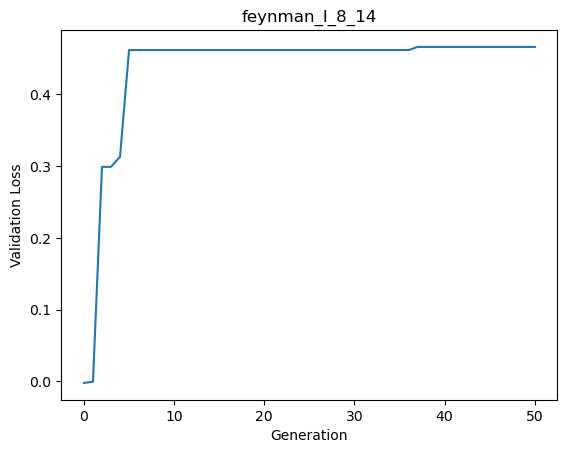

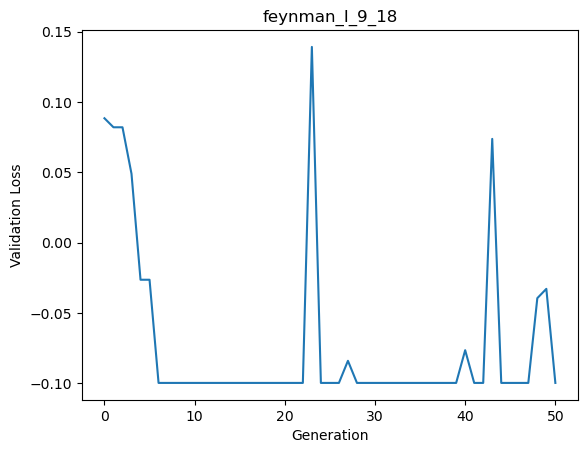

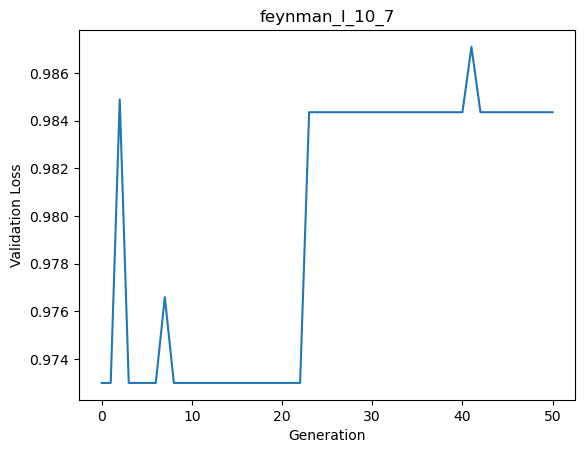

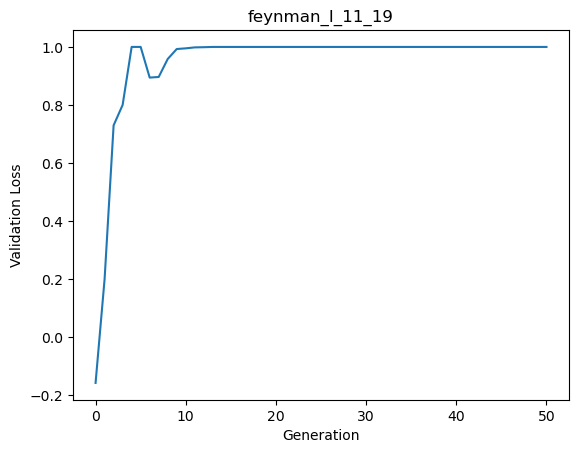

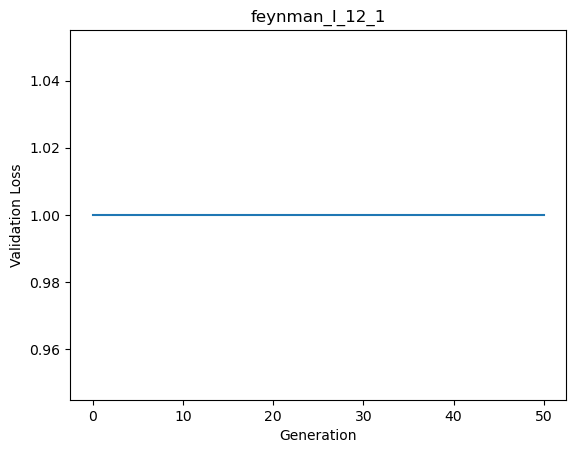

In [135]:
for name, history in loss_histories.items():
    plt.plot(history)
    plt.ylabel('Validation Loss')
    plt.xlabel('Generation')
    plt.title(name)
    plt.show()

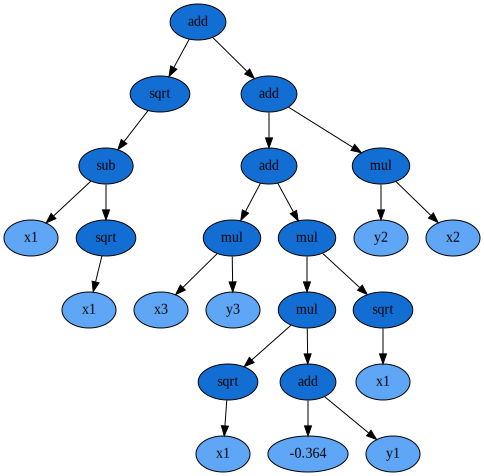

In [136]:
dot_data=results.loc[3,"equation"].export_graphviz()
graphviz.Source(dot_data)